# SOM visualization and clustering

In [126]:
import signal_ana as ana
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the signals
df = ana.load_signals('/eos/user/l/llayer/features_30.h5')
# Exclude the eruption days
eruption_days = [ ('2019-07-03', '2019-07-04'), ('2019-08-28', '2019-08-29'), ('2019-08-29', '2019-08-30')]
df = ana.exclude_days(df, eruption_days)
features_wf = ana.get_features(df, 'waveform')
features_lpc = ana.get_features(df, 'lpc_coeff')
features_amp = ana.get_features(df, 'amplitude')

In [97]:
# Plot the errors of the som
def plot_error_som(q_error, t_error, iter_x):
    plt.figure(figsize=(6,4), dpi=80)
    plt.plot(iter_x, q_error)
    plt.ylabel('quantization error', fontsize=15)
    plt.xlabel('iteration', fontsize=15)
    plt.show()

    plt.figure(figsize=(6,4), dpi=80)
    plt.plot(iter_x, t_error)
    plt.ylabel('topological error', fontsize=15)
    plt.xlabel('iteration', fontsize=15)
    plt.show()

In [100]:
from matplotlib.gridspec import GridSpec
from matplotlib import cm

def plot_distance(som, size_x, size_y):
    
    cmap = cm.get_cmap('coolwarm')
    dmap = som.distance_map() 
    
    plt.figure(figsize=(8, 8), dpi=100)
    weights = som.get_weights()
    
    print(weights.shape)
    
    the_grid = GridSpec(size_x, size_y)
    
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            
            ax = plt.subplot(the_grid[i, j])
            plt.plot(weights[i,j], linewidth=1, color = 'k')
            c = cmap(dmap[i, j])
            ax.set_facecolor((c[0], c[1], c[2]))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

In [146]:
def plot_density(features, som, size_x, size_y):
    
    win_map = som.win_map(features)
    
    def density_map():
    
        dm = np.zeros((size_x, size_y))
        for i in range(size_x):
            for j in range(size_y):
                dm[i,j] = len(win_map[i,j])
        return dm/dm.max()
    
    density = density_map()
    
    cmap = cm.get_cmap('coolwarm') #gray_r')
    
    plt.figure(figsize=(8, 8), dpi=100)
    weights = som.get_weights()
    the_grid = GridSpec(size_x, size_y)

    for i in range(size_x):
        for j in range(size_y):

            ax = plt.subplot(the_grid[i, j])
            c = cmap(density[i, j])
            ax.set_facecolor((c[0], c[1], c[2]))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            plt.plot(weights[i, j], linewidth=1, color = 'k')

    plt.show()

In [127]:
from sklearn.cluster import KMeans

# Run kmeans on the weights of the som
def kmeans_som(som, features, size_x, size_y, n_clusters=4):
    
    weights = som.get_weights()
    weights = weights.reshape(size_x * size_y, weights.shape[2])

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    pred_weights = kmeans.fit_predict(weights)

    weights = weights.reshape(size_x , size_y, weights.shape[1])
    pred_weights = pred_weights.reshape(size_x , size_y,)

    
    #colors = [ cm.Spectral(float(i) / n_clusters) for i in range(n_clusters)]
    win_map = som.win_map(features)
    plt.figure(figsize=(8, 8), dpi=100)
    the_grid = GridSpec(size_x, size_y)

    for i in range(size_x):
        for j in range(size_y):

            ax = plt.subplot(the_grid[i, j])
            c = pred_weights[i,j]
            ax.set_facecolor(colors[c])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            if (i, j) in win_map.keys():
                plt.plot(np.mean(win_map[i, j], axis=0), color='k', linewidth=1)

    plt.show()

    return pred_weights, kmeans.cluster_centers_

In [136]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

def silhouette_cls(X, max_cls = 8):

    range_n_clusters = range(2, max_cls+1)
    silhouette_scores = []
    for n_clusters in range_n_clusters:

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_scores.append( silhouette_score(X, cluster_labels) )
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_scores[-1])
        
    fig = plt.figure(figsize=(6,4), dpi=80)
    plt.scatter(range_n_clusters, silhouette_scores)
    plt.ylabel('Silhouette score', fontsize=15)
    plt.xlabel('Clusters', fontsize=15)
    plt.show()
    
    return silhouette_scores

In [135]:
def to_som_cluster(feat):
    
    winning = som.winner(feat)
    cluster = kmeans_cluster[winning]
    return (cluster + 1)%2

In [141]:
def plot_silhouette(X, n_clusters):

    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=(6, 6), dpi=100)
    ax1 = plt.subplot(111)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.Spectral(float(i) / n_clusters)
        color = colors[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette score",  fontsize=15)
    ax1.set_ylabel("Cluster", fontsize=15)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

In [193]:
import numpy as np
from matplotlib import cm
from datetime import datetime, date
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec


def cluster_time(df, col, n_clusters, timebins=200, plot_hist = True):

    df['time_int'] = df.time.astype(np.int64)
    x, y = df['time_int'], df[col]

    
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=(timebins, n_clusters))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]+1]
    err1, err2 = ana.get_erruption_time()

    fig = plt.figure(figsize=(8, 6), dpi=100)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05) 
    ax0 = plt.subplot(gs[0])
    
    cluster_bins = []
    for i in range(n_clusters):
    # the histogram of the data
        #fig = plt.figure(1, figsize=(8, 6))
        #ax = fig.add_subplot(111)
        cluster = df[df[col] == i]
        n, bins, patches = ax0.hist(cluster['time_int'], timebins, alpha=0.75, label = 'Cluster ' + str(i))
        cluster_bins.append(n)
        
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    ax0.set_xlim(1.56009035e+18, 1.56838442e+18)
    ax0.axvline(x=err1, color='r', linestyle='dashed', linewidth=2, label = 'Paroxism')
    ax0.axvline(x=err2, color='r', linestyle='dashed', linewidth=2)
    ax0.set_xticklabels([]) 
    ax0.set_ylabel("Counts",  fontsize=15)
    plt.legend(loc = 'upper left')
    
    #plt.show()
    ax1 = plt.subplot(gs[1])
    if n_clusters == 2:
        
        #fig = plt.figure(1, figsize=(8, 6))
        #ax = fig.add_subplot(111)
        center = (bins[:-1] + bins[1:]) / 2
        ratio = [ (float(cls1) / float(cls2)) for cls1, cls2 in zip(cluster_bins[0], cluster_bins[1])]
        print(ratio)
        ax1.plot(center, ratio, linewidth=2)
        start, end = 1.56009035e+18, 1.56838442e+18
        ax1.set_xlim(start, end)
        ax1.axvline(x=err1, color='r', linestyle='dashed', linewidth=2)
        ax1.axvline(x=err2, color='r', linestyle='dashed', linewidth=2)
        ax1.axhline(1, color='k', linestyle='dashed', linewidth=1)
        #ax1.xaxis.set_ticks(np.arange(start, end, (end - start / 10)))
        ax1.set_xticklabels([datetime.fromtimestamp(ts / 1e9).strftime('%D') for ts in ax1.get_xticks()])
        ax1.set_ylabel("Ratio",  fontsize=15)
        #ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
        plt.xticks(rotation=45)
    plt.show()

## 1. Filtered signal

### 25x25 SOM

In [3]:
som_opt = pd.read_hdf('data/som_skopt_wf.h5')

In [ ]:
wf = pd.read_hdf('data/tsne_wf.h5', 'frame')

In [4]:
som_opt.head()

,call,learning_rate,sigma,niter,score,q_error,t_error
0,46,0.100535,1.631357,100000.000000,0.250373,0.243912,0.056512
1,35,0.177623,1.447859,23545.542036,0.259613,0.245663,0.083958
2,36,0.108394,1.164396,21546.580028,0.259813,0.235290,0.110188
3,30,0.164352,1.226757,31574.960333,0.260973,0.234443,0.114645
4,21,0.053753,1.347131,26566.404798,0.262835,0.251374,0.076767


In [103]:
# Train som

size_x = 25
size_y = 25
niter =  20000 #59000 #10000 100000
sigma =  1.5 #1 #2.2 # #0.3 1.63
learning_rate= 0.1 #.013 #.5 0.1
pca=False
random_seed = 4

In [104]:
som, iter_x, q_error, t_error = ana.run_som(features_wf, size_x, size_y, niter = niter, sigma=sigma, learning_rate=learning_rate, 
                                              pca=pca, plot_error = True, random_seed = random_seed)
#som = ana.run_som(features_wf, size_x, size_y, niter = niter, sigma=sigma, learning_rate=learning_rate, 
#                                              pca=pca, plot_error = False, random_seed = random_seed)

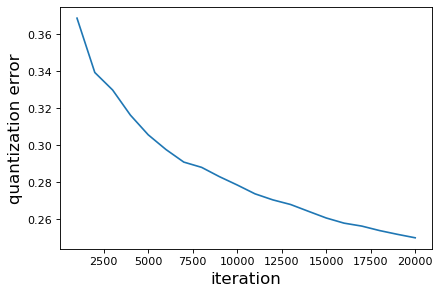

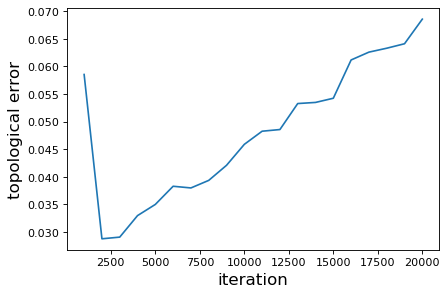

In [105]:
plot_error_som(q_error, t_error, iter_x)

(25, 25, 259)


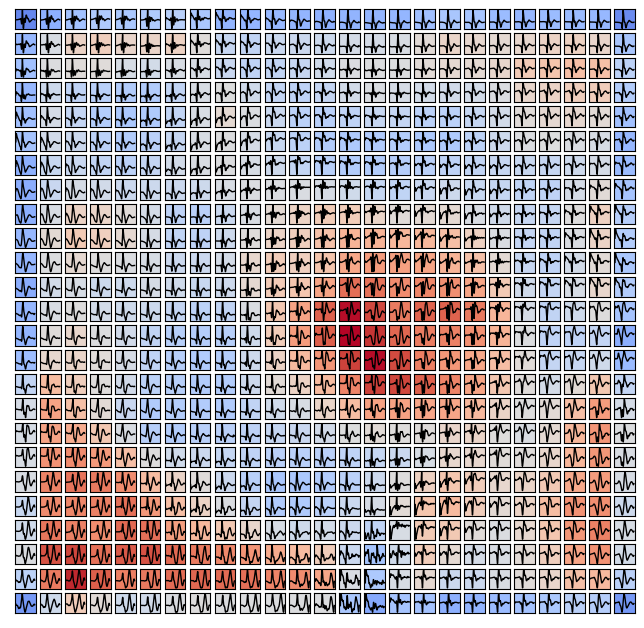

In [106]:
# distance map
plot_distance(som, size_x, size_y)

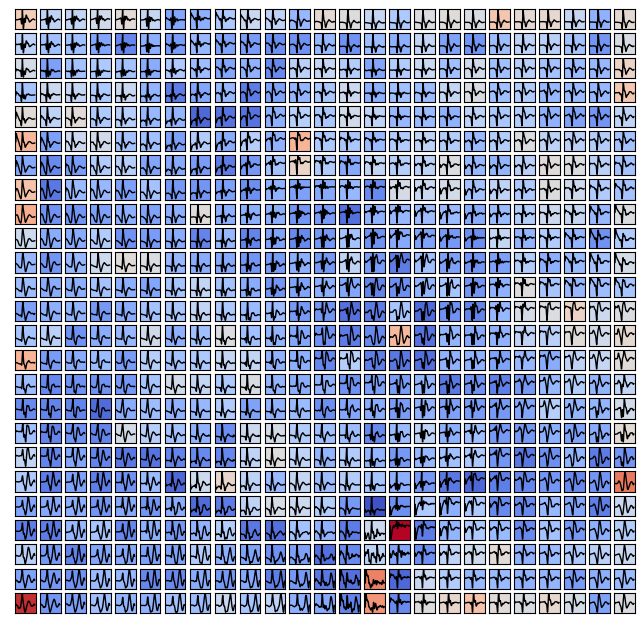

In [147]:
plot_density(features_wf, som, size_x, size_y)

In [ ]:
weights = som.get_weights()
weights = weights.reshape(size_x * size_y, weights.shape[2])

For n_clusters = 2 The average silhouette_score is : 0.318447605702
For n_clusters = 3 The average silhouette_score is : 0.28916072368
For n_clusters = 4 The average silhouette_score is : 0.254933185162
For n_clusters = 5 The average silhouette_score is : 0.23347465165
For n_clusters = 6 The average silhouette_score is : 0.24329936313
For n_clusters = 7 The average silhouette_score is : 0.243665276209
For n_clusters = 8 The average silhouette_score is : 0.228330585101


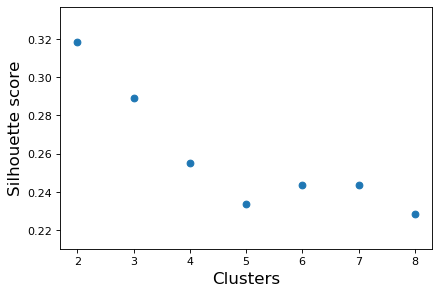

[0.31844760570168451,
 0.28916072367960927,
 0.25493318516219343,
 0.23347465164971626,
 0.2432993631296394,
 0.2436652762087344,
 0.22833058510076548]

In [137]:
silhouette_cls(weights, max_cls = 8)

For n_clusters = 2 The average silhouette_score is : 0.318447605702


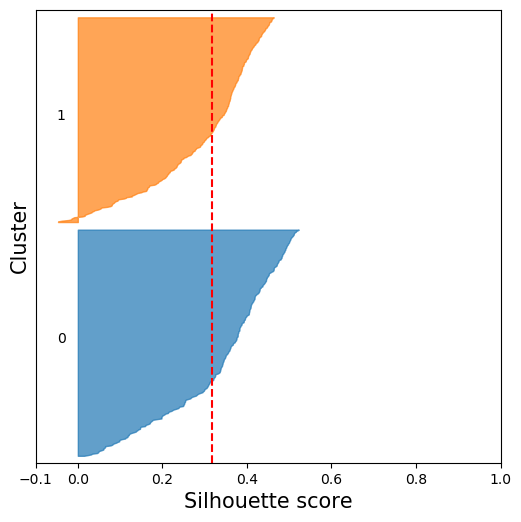

In [142]:
plot_silhouette(weights, 2)

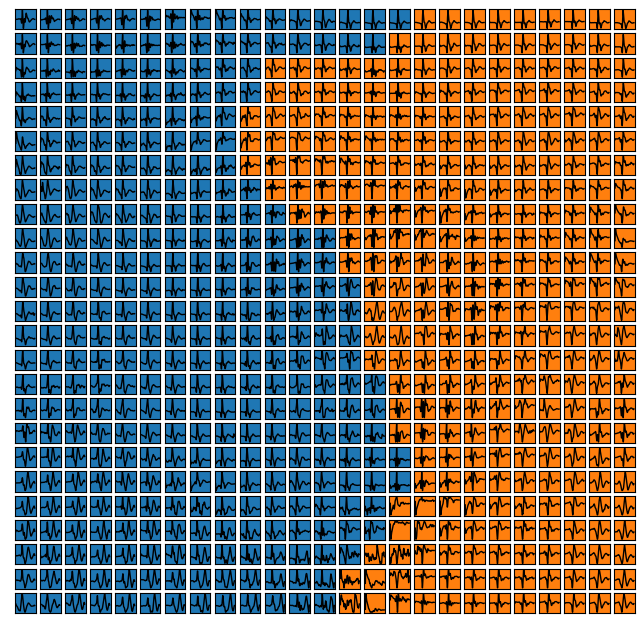

In [128]:
kmeans_cluster, centers = kmeans_som(som, features_wf, size_x, size_y, n_clusters=2)

For n_clusters = 3 The average silhouette_score is : 0.28916072368


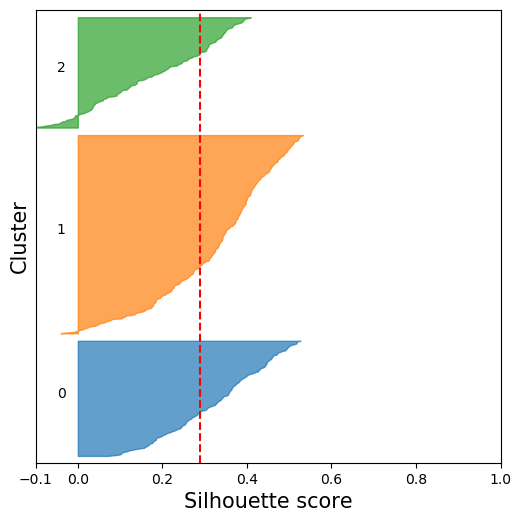

In [152]:
plot_silhouette(weights, 3)

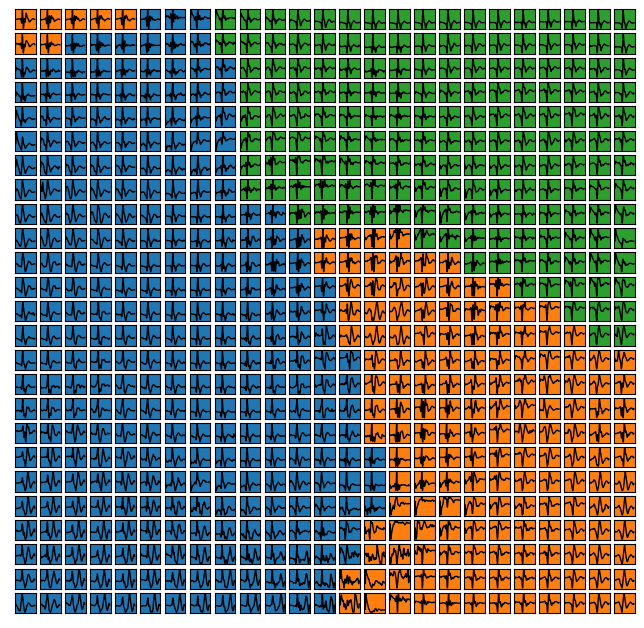

In [153]:
kmeans_cluster_3, centers_3 = kmeans_som(som, features_wf, size_x, size_y, n_clusters=3)

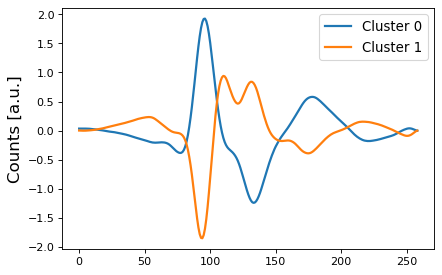

In [134]:
def plot_centers(centers):
    
    fig = plt.figure(figsize=(6,4), dpi=80)
    for i in range(len(centers)):
        plt.plot(centers[i], linewidth = 2, label = 'Cluster ' + str(i))
    plt.ylabel("Counts [a.u.]",  fontsize=15)
    plt.legend(loc='upper right', prop={'size': 12})
    
plot_centers(centers)

In [144]:
wf['kmeans_cluster'] = np.array([to_som_cluster(f) for f in features_wf])

[1.4444444444444444, 0.5034013605442177, 1.768421052631579, 2.857142857142857, 3.96875, 4.578947368421052, 0.6216216216216216, 0.8446215139442231, 1.7554347826086956, 1.412280701754386, 2.843283582089552, 4.666666666666667, 5.947368421052632, 5.0344827586206895, 4.073684210526316, 3.875, 5.141304347826087, 1.1977611940298507, 1.5491071428571428, 1.0, 0.5508474576271186, 0.75, 0.6666666666666666, 0.4051724137931034, 0.22988505747126436, 0.2079646017699115, 0.38922155688622756, 0.267515923566879, 0.5721518987341773, 0.3411371237458194, 0.27467811158798283, 0.17739130434782607, 0.347953216374269, 0.27596439169139464, 0.41745283018867924, 0.32212885154061627, 0.6294964028776978, 0.7688172043010753, 0.41448382126348227, 0.3786008230452675, 0.875, 1.894736842105263, 1.9830508474576272, 1.44, 1.6754385964912282, 1.5245901639344261, 2.1076923076923078, 1.7232142857142858, 1.1948051948051948, 1.1045751633986929]


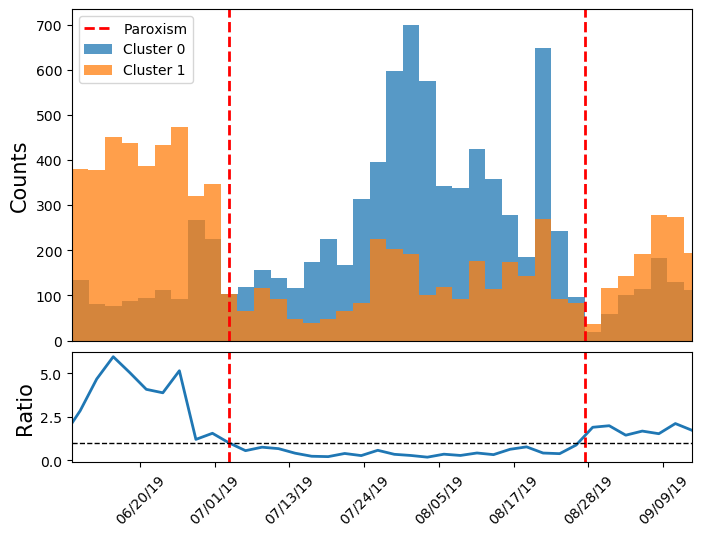

In [151]:
cluster_time(wf, 'kmeans_cluster', 2, timebins=50)

### 10 x 6 SOM

In [154]:
size_x = 10
size_y = 6
niter = 50000 #20000 #10000
sigma = 1.23 # #0.3
learning_rate= .04 #.5
pca=False
random_seed = 2

In [155]:
som, iter_x, q_error, t_error = ana.run_som(features_wf, size_x, size_y, niter = niter, sigma=sigma, learning_rate=learning_rate, 
                                              pca=pca, plot_error = True, random_seed = random_seed)

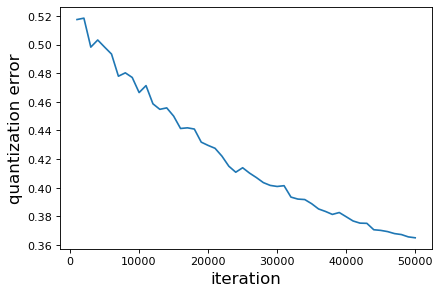

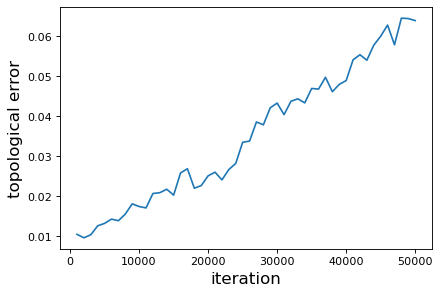

In [156]:
plot_error_som(q_error, t_error, iter_x)

(10, 6, 259)


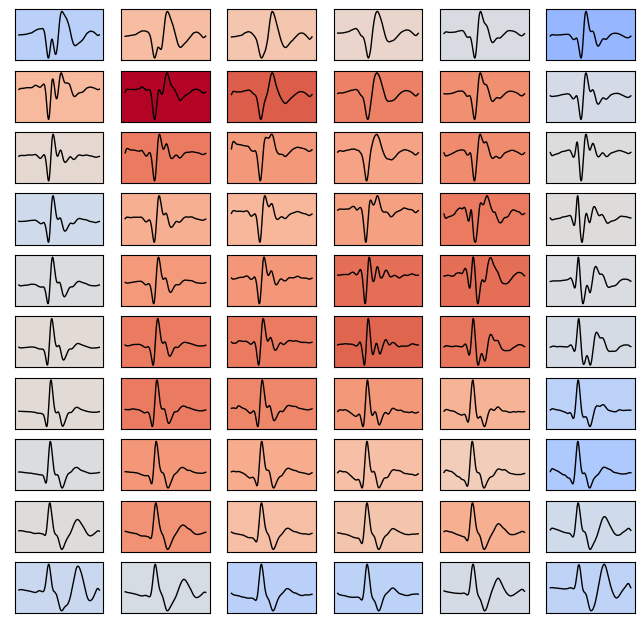

In [157]:
# distance map
plot_distance(som, size_x, size_y)

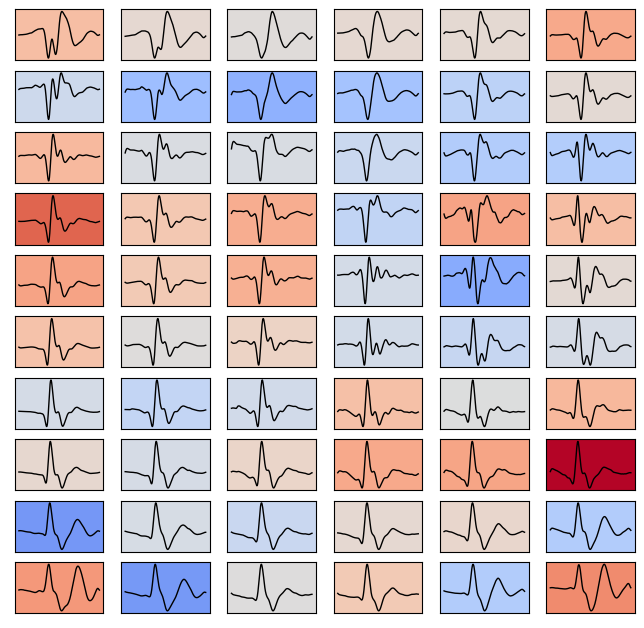

In [158]:
plot_density(features_wf, som, size_x, size_y)

In [160]:
weights = som.get_weights()
weights = weights.reshape(size_x * size_y, weights.shape[2])

For n_clusters = 2 The average silhouette_score is : 0.39224033078
For n_clusters = 3 The average silhouette_score is : 0.331382935438
For n_clusters = 4 The average silhouette_score is : 0.289879179989
For n_clusters = 5 The average silhouette_score is : 0.265038228368
For n_clusters = 6 The average silhouette_score is : 0.27701537723
For n_clusters = 7 The average silhouette_score is : 0.265371455857
For n_clusters = 8 The average silhouette_score is : 0.278013317656


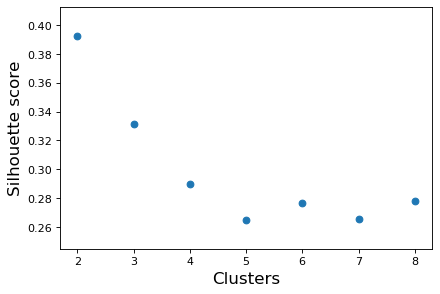

[0.39224033078007475,
 0.33138293543845859,
 0.28987917998912077,
 0.26503822836835828,
 0.27701537722968783,
 0.26537145585682326,
 0.27801331765564213]

In [161]:
silhouette_cls(weights, max_cls = 8)

For n_clusters = 2 The average silhouette_score is : 0.39224033078


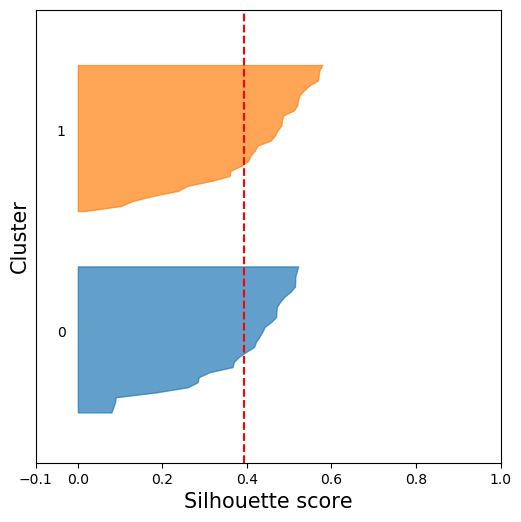

In [162]:
plot_silhouette(weights, 2)

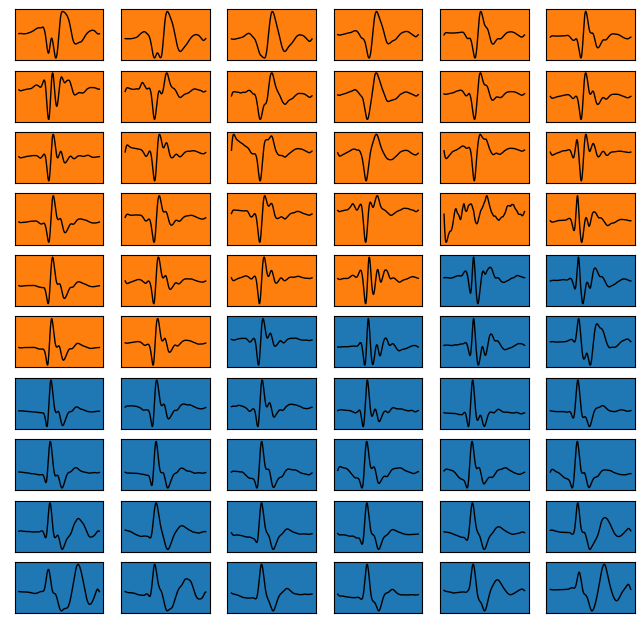

In [163]:
kmeans_cluster, centers = kmeans_som(som, features_wf, size_x, size_y, n_clusters=2)

For n_clusters = 3 The average silhouette_score is : 0.331382935438


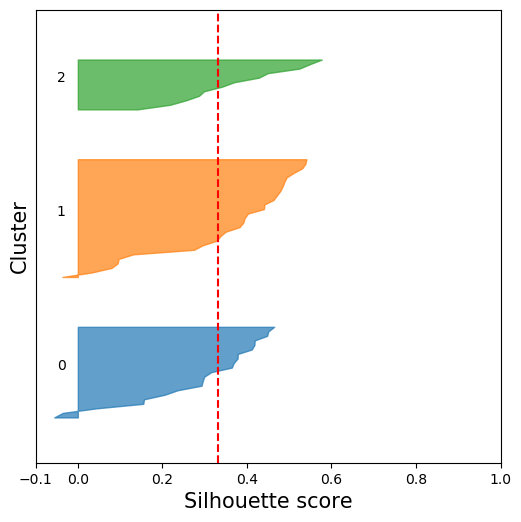

In [164]:
plot_silhouette(weights, 3)

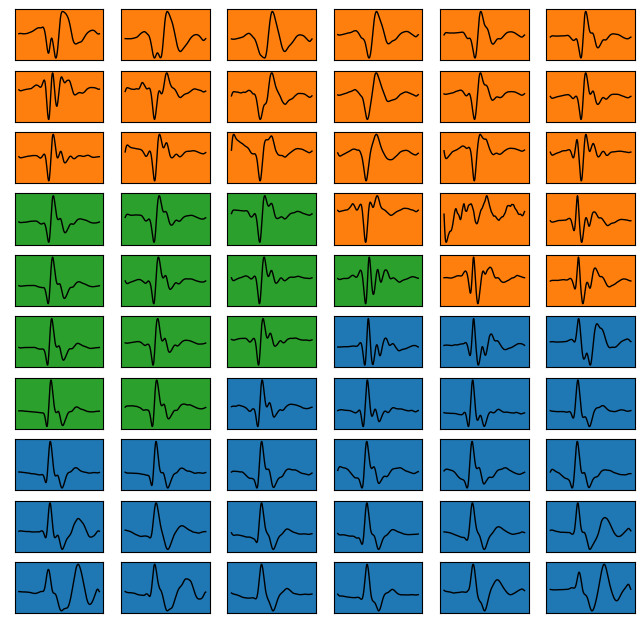

In [165]:
kmeans_cluster_3, centers_3 = kmeans_som(som, features_wf, size_x, size_y, n_clusters=3)

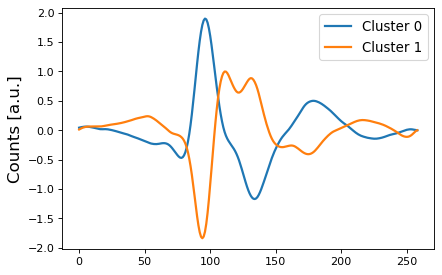

In [166]:
def plot_centers(centers):
    
    fig = plt.figure(figsize=(6,4), dpi=80)
    for i in range(len(centers)):
        plt.plot(centers[i], linewidth = 2, label = 'Cluster ' + str(i))
    plt.ylabel("Counts [a.u.]",  fontsize=15)
    plt.legend(loc='upper right', prop={'size': 12})
    
plot_centers(centers)

In [167]:
wf['kmeans_cluster'] = np.array([to_som_cluster(f) for f in features_wf])

[1.5644171779141105, 0.5827338129496403, 1.8387096774193548, 3.128205128205128, 4.161290322580645, 5.057142857142857, 0.6216216216216216, 0.8975409836065574, 1.7204301075268817, 1.4380530973451326, 2.8796992481203008, 4.7375, 6.219178082191781, 5.104651162790698, 4.063157894736842, 4.11214953271028, 5.208791208791209, 1.1977611940298507, 1.5491071428571428, 1.0097087378640777, 0.5041322314049587, 0.7960526315789473, 0.6911764705882353, 0.45535714285714285, 0.2441860465116279, 0.22972972972972974, 0.4409937888198758, 0.27564102564102566, 0.6272965879265092, 0.35413153456998314, 0.2988338192419825, 0.196113074204947, 0.375, 0.32, 0.41745283018867924, 0.3342776203966006, 0.663003663003663, 0.7593582887700535, 0.3804511278195489, 0.40756302521008403, 0.8947368421052632, 1.894736842105263, 1.6417910447761195, 0.9918032786885246, 1.4596774193548387, 1.40625, 2.0606060606060606, 1.6521739130434783, 1.2684563758389262, 1.0379746835443038]


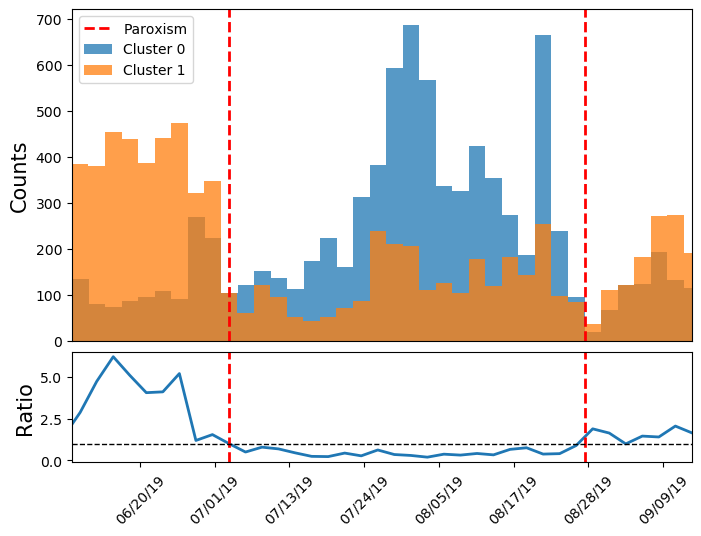

In [168]:
cluster_time(wf, 'kmeans_cluster', 2, timebins=50)

## Filtered signal + LPC + Amplitude

In [169]:
features_full = np.concatenate((features_wf, features_lpc, features_amp),axis=1)

In [190]:
full = pd.read_hdf('data/tsne_full.h5', 'frame')

In [170]:
som_opt = pd.read_hdf('data/som_skopt_full.h5')

In [171]:
som_opt.head()

,call,learning_rate,sigma,niter,score,q_error,t_error
0,39,0.065055,1.306735,79468.734834,0.231339,0.217119,0.079856
1,44,0.064320,1.270117,100000.000000,0.234290,0.215251,0.092516
2,42,0.054599,1.555019,60542.185134,0.238459,0.228810,0.067146
3,25,0.010000,1.516458,100000.000000,0.244077,0.238373,0.052461
4,48,0.062825,1.777796,44349.433578,0.244697,0.238963,0.052664


In [172]:
# Train som

size_x = 25
size_y = 25
niter =  40000 
sigma =  1.5 
learning_rate= 0.05 
pca=False
random_seed = 4

In [179]:
som, iter_x, q_error, t_error = ana.run_som(features_full, size_x, size_y, niter = niter, sigma=sigma, learning_rate=learning_rate, 
                                              pca=pca, plot_error = True, random_seed = random_seed)
#som = ana.run_som(features_wf, size_x, size_y, niter = niter, sigma=sigma, learning_rate=learning_rate, 
#                                              pca=pca, plot_error = False, random_seed = random_seed)

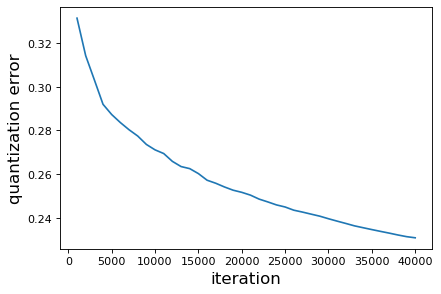

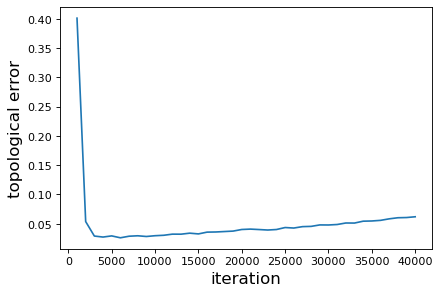

In [180]:
plot_error_som(q_error, t_error, iter_x)

(25, 25, 367)


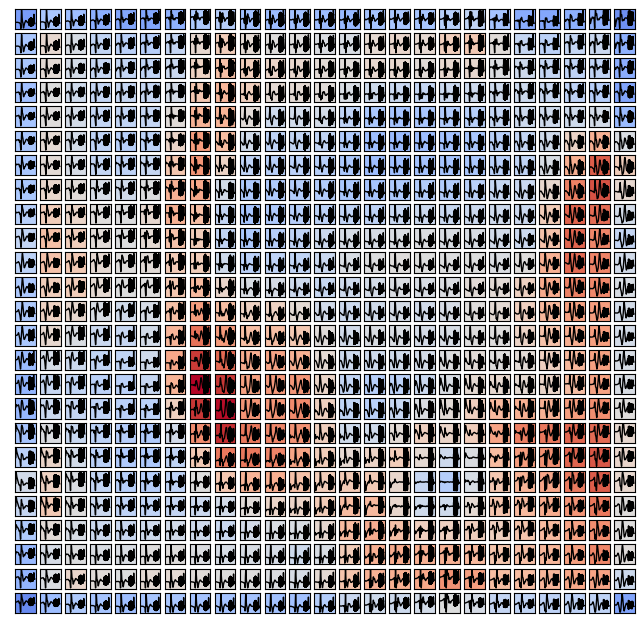

In [181]:
# distance map
plot_distance(som, size_x, size_y)

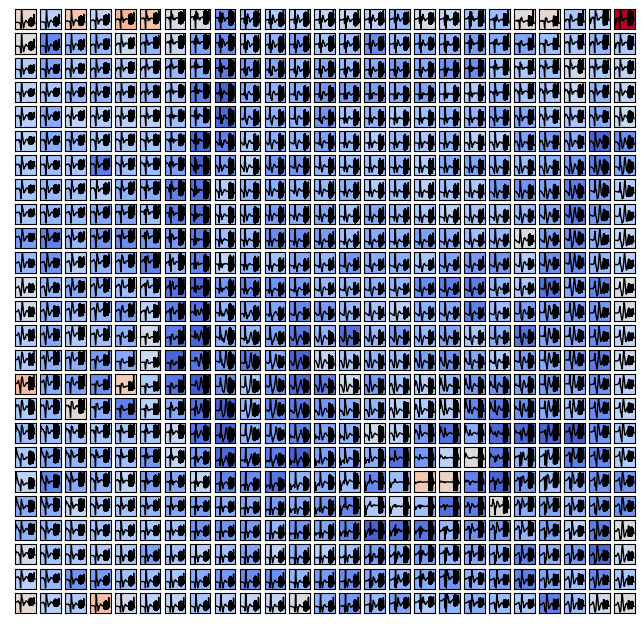

In [183]:
plot_density(features_full, som, size_x, size_y)

In [184]:
weights = som.get_weights()
weights = weights.reshape(size_x * size_y, weights.shape[2])

For n_clusters = 2 The average silhouette_score is : 0.313929760958
For n_clusters = 3 The average silhouette_score is : 0.274282304017
For n_clusters = 4 The average silhouette_score is : 0.255756016325
For n_clusters = 5 The average silhouette_score is : 0.232332025514
For n_clusters = 6 The average silhouette_score is : 0.213189498031
For n_clusters = 7 The average silhouette_score is : 0.230829851414
For n_clusters = 8 The average silhouette_score is : 0.213145966879


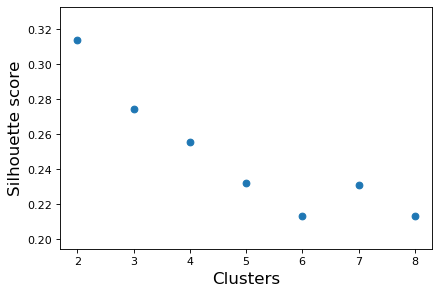

[0.31392976095838954,
 0.27428230401731735,
 0.25575601632531891,
 0.23233202551364229,
 0.21318949803144879,
 0.2308298514137993,
 0.21314596687925372]

In [185]:
silhouette_cls(weights, max_cls = 8)

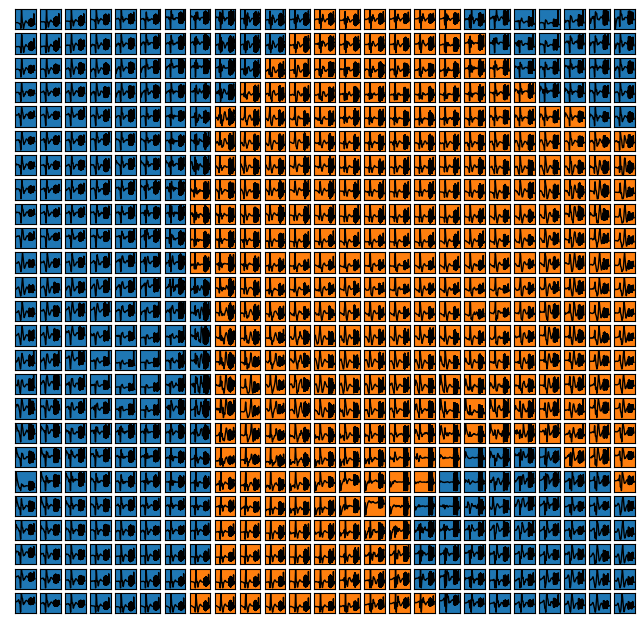

In [187]:
kmeans_cluster, centers = kmeans_som(som, features_full, size_x, size_y, n_clusters=2)

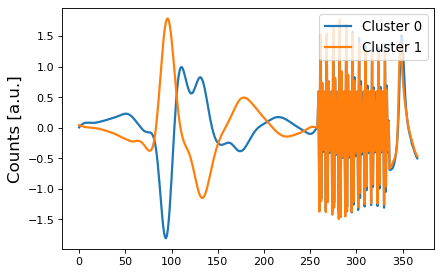

In [188]:
plot_centers(centers)

In [191]:
full['kmeans_cluster'] = np.array([to_som_cluster(f) for f in features_full])

[1.416184971098266, 0.5241379310344828, 1.711340206185567, 2.926829268292683, 4.0, 4.578947368421052, 0.6666666666666666, 0.9090909090909091, 1.7704918032786885, 1.4273127753303965, 3.12, 4.961038961038961, 6.450704225352113, 5.093023255813954, 3.9690721649484537, 3.963636363636364, 5.569767441860465, 1.205992509363296, 1.5605381165919283, 1.0196078431372548, 0.525, 0.7843137254901961, 0.7037037037037037, 0.3252032520325203, 0.22988505747126436, 0.21973094170403587, 0.38461538461538464, 0.2563291139240506, 0.599483204134367, 0.34, 0.2584745762711864, 0.15924657534246575, 0.2949438202247191, 0.26099706744868034, 0.39443155452436196, 0.3047091412742382, 0.6272401433691757, 0.7315789473684211, 1.0816326530612246, 0.384297520661157, 0.8, 1.75, 2.339622641509434, 1.4795918367346939, 1.9901960784313726, 1.8518518518518519, 2.706422018348624, 1.9047619047619047, 1.2091503267973855, 1.0909090909090908]


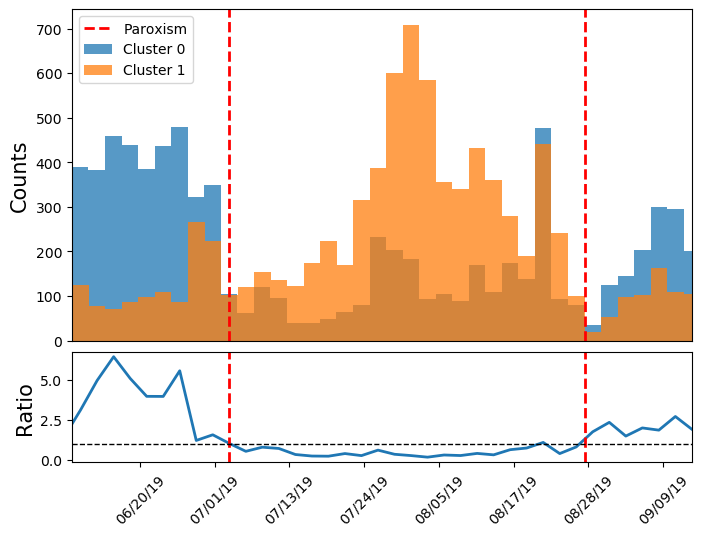

In [194]:
cluster_time(full, 'kmeans_cluster', 2, timebins=50)